In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.colors as mcolors
from matplotlib.transforms import Bbox
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import scvi
import scanpy as sc
import itertools
from sklearn.preprocessing import MinMaxScaler
import anndata as an
import scanpy.external as sce
from matplotlib.path import Path
import scipy
import scipy.sparse as sp
import gget
import time
import sklearn
import torch
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.manifold import MDS
from brokenaxes import brokenaxes
import sklearn.metrics as sm
from adjustText import adjust_text

from importlib import reload

# local imports
import utils as ut
import plotting as plt2

sc.settings.verbosity = 3 

# Load Data

In [2]:
fpath = "/scratch/indikar_root/indikar1/shared_data/scanvi_model_minimal/imputed_adata/hvg13000.h5ad"
adata = sc.read_h5ad(fpath)
adata.X = adata.layers['scanvi_counts'].copy()

# make counts out of 10000
scale_expression  = 1e4
adata.layers['scaled_scanvi'] = np.log1p(adata.layers['scanvi_counts'] * scale_expression)

sc.tl.embedding_density(adata, basis='umap')

sc.logging.print_memory_usage()
print(adata)

computing density on 'umap'
--> added
    'umap_density', densities (adata.obs)
    'umap_density_params', parameter (adata.uns)
Memory usage: current 10.97 GB, difference +10.97 GB
AnnData object with n_obs × n_vars = 61115 × 13000
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'batch', 'umap_density'
    uns: 'neighbors', 'pca', 'umap', 'umap_density_params'
    obsm: 'X_harmony', 'X_pca', 'X_scanorama', 'X_scanvi', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scanvi_counts', 'scaled_scanvi'
    obsp: 'connectivities', 'distances'


# Load gene sets

In [3]:
reload(ut)
fpath = "../resources/PanglaoDB_Augmented_2021.txt"
features = ut.load_pathway(fpath)

[x for x in features.columns if 'hemato' in x.lower()]

# pathway = 'Hematopoietic Stem Cells'
pathway = 'Fibroblasts'
query_genes = list(features[features[pathway]].index)
print(len(query_genes))
query_genes[:10]

232


['RARRES2',
 'CELA1',
 'LUM',
 'PRRX1',
 'SCARA5',
 'COL1A1',
 'COL5A2',
 'COL5A1',
 'FNDC1',
 'COL12A1']

In [4]:
fpath = "../resources/scenic.tf_list.txt"
tf_list = [x.strip() for x in open(fpath)]
tf_list[:10]

['ZNF354C',
 'KLF12',
 'ZNF143',
 'ZIC2',
 'ZNF274',
 'SP2',
 'ZBTB7A',
 'BCL6B',
 'ZBTB49',
 'ZIC1']

# Filter dataset

In [5]:
mask = (adata.obs['dataset'] != 'pellin')
adata = adata[mask, :].copy()

mask = (adata.obs['dataset'] != 'tabula_sapiens')
adata = adata[mask, :].copy()

adata

AnnData object with n_obs × n_vars = 33748 × 13000
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'batch', 'umap_density'
    uns: 'neighbors', 'pca', 'umap', 'umap_density_params'
    obsm: 'X_harmony', 'X_pca', 'X_scanorama', 'X_scanvi', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scanvi_counts', 'scaled_scanvi'
    obsp: 'connectivities', 'distances'

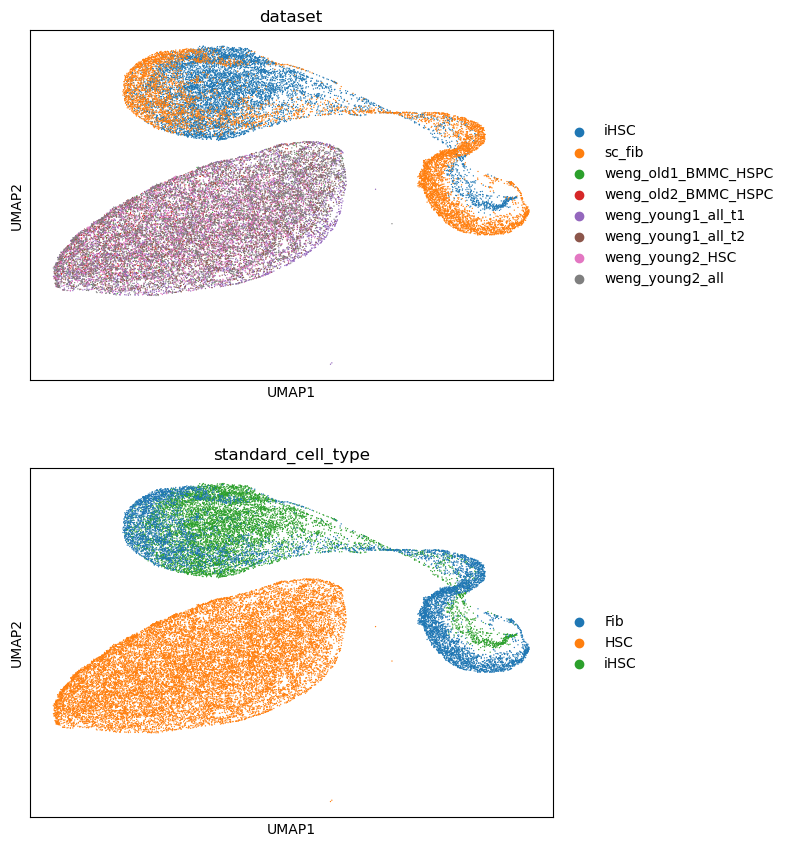

In [6]:
sc.pl.umap(
    adata,
    color=[
        'dataset',
        'standard_cell_type',
    ],
    ncols=1,
)

In [7]:
# break

# aggregate distances

In [ ]:
aggdata = sc.get.aggregate(
    adata,
    by='standard_cell_type',
    func='mean',
    layer='scaled_scanvi'
)

aggdata.X = aggdata.layers['mean'].copy()

df = aggdata.to_df()
df = df.T
df.head()

In [ ]:
A = df.corr()
n = A.shape[0]
plot_n = n * 0.75

plt.rcParams['figure.dpi'] = 200

sns.clustermap(
    A, 
    square=True,
    lw=1,
    figsize=(plot_n, plot_n),
    annot=True,
    cbar_pos=None,
    fmt=".3f",
    annot_kws={'fontsize' : 6},
    cbar_kws={'shrink' : 0.45},
)
plt.suptitle('All Gene Correlation', y=1.1)

plt.gca().tick_params(axis='y', rotation=0)

# Distances

In [ ]:
metric = 'cosine'
A = sm.pairwise_distances(
    df.T, 
    metric=metric,
)

# Convert to a DataFrame
A = pd.DataFrame(
    A, 
    index=df.columns,
    columns=df.columns,
)

n = A.shape[0]
plot_n = n * 0.75

plt.rcParams['figure.dpi'] = 200

sns.clustermap(
    A, 
    square=True,
    lw=1,
    figsize=(plot_n, plot_n),
    annot=True,
    cbar_pos=None,
    fmt=".3f",
    annot_kws={'fontsize' : 6},
    cbar_kws={'shrink' : 0.45},
)
plt.suptitle(f'All Gene Distance ({metric})', y=1.1)

plt.gca().tick_params(axis='y', rotation=0)

# Load annotations and filter

In [ ]:
# load the obs annotations
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/obs/merged_scfib_obs.csv"
obs = pd.read_csv(fpath)

obs['new_cluster_str'] = obs['new_cluster'].apply(lambda x: f"F{int(x) + 1}")

cluster_map = dict(zip(obs['cell_id'].values, obs['cluster_str'].values))
new_cluster_map = dict(zip(obs['cell_id'].values, obs['new_cluster_str'].values))

adata.obs['cluster_str'] = adata.obs.index.map(cluster_map)
adata.obs['new_cluster_str'] = adata.obs.index.map(new_cluster_map)

# Filter cluster C6
mask = (adata.obs['cluster_str'] == 'C6') & (adata.obs['dataset'] == 'iHSC')
adata = adata[~mask, :].copy()

# filter out low-quality FB clusters
mask = (adata.obs['new_cluster_str'].isin(['F7', 'F8'])) & (adata.obs['dataset'].isin(['iHSC', 'sc_fib']))
adata = adata[~mask, :].copy()

# filter out tabula sapiens

print(adata)
print()
adata.obs['cluster_str'].value_counts()

# annotate further

In [ ]:
# sort the cells by type
sorted_indices = adata.obs['standard_cell_type'].argsort()
adata = adata[sorted_indices, :].copy() 

# establish grouping
adata.obs['group'] = np.where(adata.obs['cluster_str'].isin(['C2', 'C5']), "iHSC-high", "HSC")
adata.obs['group'] = np.where(adata.obs['cluster_str'].isin(['C1', 'C3']), "iHSC-low", adata.obs['group'])
adata.obs['group'] = np.where(adata.obs['cluster_str'] == 'C4', "BJ Fib", adata.obs['group'])
adata.obs['group'] = np.where(adata.obs['dataset'] == 'sc_fib', "BJ Fib", adata.obs['group'])

print(adata.obs['group'].value_counts())
print()

adata.obs['group2'] = adata.obs['cluster_str'].copy()
adata.obs['group2'] = np.where(adata.obs['cell_label'] == 'HSC', 'HSC', adata.obs['group2'])
adata.obs['group2'] = np.where(adata.obs['dataset'] == 'sc_fib', 'Bj Fib', adata.obs['group2'])

print(adata.obs['group2'].value_counts())
print()

In [ ]:
sc.pl.umap(
    adata,
    color=[
        'group',
        'group2',
    ],
    ncols=1,
)

# Aggregate Data

In [ ]:
aggdata = sc.get.aggregate(
    adata,
    by='group',
    func='mean',
    layer='scaled_scanvi'
)

aggdata.X = aggdata.layers['mean']
df = aggdata.to_df(layer='mean')
df = df.T
df.head()

# MDS

In [ ]:
d_func = scipy.spatial.distance.cosine
# d_func = scipy.spatial.distance.euclidean

comps = {
    'hsc_to_bj_fib': ('BJ Fib', 'HSC'),
    'ihsc_high_to_hsc': ('iHSC-high', 'HSC'),
    'ihsc_low_to_hsc': ('iHSC-low', 'HSC'),
    'ihsc_low_to_bj_fib': ('iHSC-low', 'BJ Fib'),
    'ihsc_high_to_bj_fib': ('iHSC-high', 'BJ Fib'),
}

for k, v in comps.items():
    distance = d_func(df[v[0]], df[v[1]])
    print(f"{k} : {distance:.3f}")

In [ ]:
def scaler(vector):
  return MinMaxScaler().fit_transform(np.array(vector).reshape(-1, 1)).flatten()

In [ ]:
metric = 'cosine'
# metric = 'euclidean'

pdf = df.copy()

A = sm.pairwise_distances(
    pdf.T, 
    metric=metric,
)

# Convert to a DataFrame
A = pd.DataFrame(
    A, 
    index=pdf.columns,
    columns=pdf.columns,
)

print(A.round(3))

mds = MDS(n_components=1, dissimilarity='precomputed')
coordinates = mds.fit_transform(A)

cdf = pd.DataFrame({
    'x' : coordinates[:, 0],
    'x_scaled' : scaler(coordinates[:, 0]),
    'label' : pdf.columns,
})

cdf = cdf.sort_values("x")
cdf = cdf.reset_index(drop=True)
cdf.head()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 1

pdf = cdf.copy()

colors = [
    '#e0e0e0',    # Brighter light gray    
    '#DC143C',   # Crimson red/

    '#FFA500',    # Bright orange 
    '#008080',    # Vivid teal
    
]

sns.scatterplot(
    data=pdf,
    x='x_scaled',
    y=0.0,
    hue='label',
    marker='o',
    ec='k',
    lw=0.75,
    s=50,
    palette=colors,
    legend=False,
)

plt.axhline(y=0, zorder=0, lw=1, c='k')

sns.despine(left=True)
plt.yticks([])
plt.ylim([-0.01, 0.01])
plt.xlabel('')
plt.gcf().patch.set_facecolor('none')
plt.gca().patch.set_facecolor('none')

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 1

pdf = cdf.copy()
pdf = pdf[pdf['label'] != 'HSC']


sns.scatterplot(
    data=pdf,
    x='x_scaled',
    y=0.0,
    hue='label',
    marker='o',
    ec='k',
    lw=0.75,
    s=50,
    palette=colors,
    legend=False,
)

plt.axhline(y=0, zorder=0, lw=1, c='k')

sns.despine(left=True)
plt.yticks([])
plt.ylim([-0.01, 0.01])
plt.xlabel('reprogramming distance')
plt.gcf().patch.set_facecolor('none')
plt.gca().patch.set_facecolor('none')

In [ ]:
# break

# Sample MDS

In [ ]:
adata.obs['group2'].value_counts()

In [ ]:
adata.obs['group'].value_counts()

In [ ]:
metric = 'cosine'
n = 250

# Sample n items from each group
sampled_df = adata.obs.groupby('group').apply(lambda x: x.sample(n=n, replace=False))
sampled_df = sampled_df.reset_index(level='group', drop=True)

print(sampled_df['group'].value_counts())

sample_idx = sampled_df.index
X = adata[sample_idx,].layers['scaled_scanvi']
print(f"{X.shape=}")

A = squareform(pdist(X, metric=metric))
A = pd.DataFrame(
    A,
    index=sampled_df.index,
    columns=sampled_df.index,
)

print(f"{A.shape=}")

mds = MDS(n_components=2, dissimilarity='precomputed')
coordinates = mds.fit_transform(A)
print(f"{coordinates.shape=}")

cdf = pd.DataFrame({
    'x' : coordinates[:, 0],
    'x_scaled' : scaler(coordinates[:, 0]),
    'group' : sampled_df['group'].values,
    'group2' : sampled_df['group2'].values,
})

cdf = cdf.sort_values(by='group')
cdf['group'] = cdf['group'].astype(str)
cdf = cdf[cdf['group'] != 'HSC']

colors = plt2.get_n_colors(4, 'gnuplot')
print(colors)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 1

sns.boxplot(
    data=cdf,
    x='x_scaled',
    y='group',
    hue='group',
    linecolor='k',
    width=0.45,
    hue_order=['BJ Fib', 'iHSC-low', 'iHSC-high'],
    palette=['grey', '#9309dd', '#d04c00',],
    # fliersize=1,
    showfliers=False, 
)

# plt.yticks([])
plt.tick_params(axis='y', which='both', length=0) 

plt.ylabel("")
plt.xlabel("")

sns.despine(left=True)

In [ ]:
metric = 'cosine'
n = 250

# Sample n items from each group
sampled_df = adata.obs.groupby('group').apply(lambda x: x.sample(n=n, replace=False))
sampled_df = sampled_df.reset_index(level='group', drop=True)

print(sampled_df['group'].value_counts())

sample_idx = sampled_df.index
X = adata[sample_idx,].layers['scaled_scanvi']
print(f"{X.shape=}")

A = squareform(pdist(X, metric=metric))
A = pd.DataFrame(
    A,
    index=sampled_df.index,
    columns=sampled_df.index,
)

print(f"{A.shape=}")

mds = MDS(n_components=2, dissimilarity='precomputed')
coordinates = mds.fit_transform(A)
print(f"{coordinates.shape=}")

cdf = pd.DataFrame({
    'x' : coordinates[:, 0],
    'x_scaled' : scaler(coordinates[:, 0]),
    'group' : sampled_df['group'].values,
    'group2' : sampled_df['group2'].values,
})

cdf = cdf.sort_values(by='group2')
cdf['group'] = cdf['group'].astype(str)
cdf['group2'] = cdf['group2'].astype(str)
cdf = cdf[cdf['group'] != 'HSC']

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 2

sns.boxplot(
    data=cdf,
    x='x_scaled',
    y='group2',
    hue='group2',
    linecolor='k',
    width=0.45,
    palette=['grey', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'],
    # fliersize=1,
    showfliers=False, 
)

# plt.yticks([])
plt.tick_params(axis='y', which='both', length=0) 

plt.ylabel("")
plt.xlabel("")

sns.despine(left=True)

In [ ]:
break

# expression and distance

In [ ]:
metric = 'cosine'
n = 500

# Sample n items from each group
sampled_df = adata.obs.groupby('group').apply(lambda x: x.sample(n=n, replace=False))
sampled_df = sampled_df.reset_index(level='group', drop=True)

sample_idx = sampled_df.index
X = adata[sample_idx,].layers['scaled_scanvi']
print(f"{X.shape=}")

A = squareform(pdist(X, metric=metric))
A = pd.DataFrame(
    A,
    index=sampled_df.index,
    columns=sampled_df.index,
)

print(f"{A.shape=}")

mds = MDS(n_components=2, dissimilarity='precomputed')
coordinates = mds.fit_transform(A)
print(f"{coordinates.shape=}")

cdf = pd.DataFrame({
    'x' : coordinates[:, 0],
    'x_scaled' : scaler(coordinates[:, 0]),
    'group' : sampled_df['group'].values,
    'group2' : sampled_df['group2'].values,
})

cdf['group'] = cdf['group'].astype(str)
cdf['group2'] = cdf['group2'].astype(str)

cdf.groupby('group')['x_scaled'].mean()

In [ ]:
result = []

exp_df = adata[sample_idx, :].to_df(layer='scaled_scanvi')
print(f"{exp_df.shape=}")

for gene in exp_df.columns:
    r, pval = scipy.stats.pearsonr(cdf['x_scaled'], exp_df[gene])
    row = df.loc[gene].to_dict()

    score = (row['iHSC-high'] - row['BJ Fib']) / (row['iHSC-high'] - row['HSC'])
    row['score'] = score
    row['gene_name'] = gene
    row['correlation'] = r
    row['p_value'] = pval
    result.append(row)

result = pd.DataFrame(result)
result = result.sort_values(by='score', ascending=False)
result.head(25)

In [ ]:
outpath = '../../../temp/mds_distance_correlation.csv'
result.to_csv(outpath, index=False)
result.head(10)

In [ ]:
reload(ut)
fpath = "../resources/PanglaoDB_Augmented_2021.txt"
features = ut.load_pathway(fpath)

# pathway = 'Hematopoietic Stem Cells'
pathway = 'Fibroblasts'
query_genes = list(features[features[pathway]].index)
query_genes = [x for x in query_genes if x in adata.var_names]

result[result['gene_name'].isin(query_genes)].sort_values(by='correlation', ascending=False).tail(25)

In [ ]:
break

In [ ]:
reload(ut)
fpath = "../resources/GO_Biological_Process_2023.txt"
features = ut.load_pathway(fpath)

pways = [x for x in features.columns if 'hemato' in x.lower()]
print(pways)

In [ ]:
pathway = "Hematopoietic Stem Cell Differentiation (GO:0060218)"
# pathway = "Hematopoietic Stem Cell Proliferation (GO:0071425)"
query_genes = list(features[features[pathway]].index)
query_genes = [x for x in query_genes if x in adata.var_names]
print(query_genes)

pdf = result[result['gene_name'].isin(query_genes)].copy()

pdf['BJ Fib'] =  pdf['BJ Fib'] / pdf['HSC']
pdf['iHSC-high'] =  pdf['iHSC-high'] / pdf['HSC']
pdf['iHSC-low'] =  pdf['iHSC-low'] / pdf['HSC']

pdf = pd.melt(
    pdf, 
    id_vars=['gene_name'],
    value_vars=['BJ Fib', 'iHSC-high', 'iHSC-low'],
)

pdf = pdf.sort_values(by='variable')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2

sns.barplot(
    data=pdf,
    x='gene_name',
    y='value',
    hue='variable',
    palette=['grey', '#d04c00', '#9309dd',],
    width=0.45,
    ec='k'
)

plt.axhline(y=1)
plt.gca().tick_params(axis='x', rotation=90)
sns.despine()


In [ ]:
break

In [ ]:
n_genes = 10
# database = 'ontology'
database = 'PanglaoDB_Augmented_2021'

pdf = result.copy()
pdf = pdf.sort_values(by='correlation', ascending=False)
edf = gget.enrichr(pdf['gene_name'].head(n_genes), database=database)

edf[['path_name', 'adj_p_val', 'overlapping_genes']].head()


In [ ]:
result = result.sort_values(by='score', ascending=False)
result.head(25)

In [ ]:
break

In [ ]:
reload(ut)
fpath = "../resources/PanglaoDB_Augmented_2021.txt"
features = ut.load_pathway(fpath)

pways = [x for x in features.columns if 'hemato' in x.lower()]
print(pways)

pathway = 'Hematopoietic Stem Cells'
# pathway = 'Fibroblasts'
query_genes = list(features[features[pathway]].index)
query_genes = [x for x in query_genes if x in adata.var_names]

result[result['gene_name'].isin(query_genes)].tail(25)

In [ ]:
result[result['gene_name'].isin(query_genes)].head(15)

In [ ]:
break

In [ ]:
metric = 'cosine'
# n = 250

# # Sample n items from each group
# sampled_df = adata.obs.groupby('group').apply(lambda x: x.sample(n=n, replace=False))
# sampled_df = sampled_df.reset_index(level='group', drop=True)

# print(sampled_df['group'].value_counts())

# sample_idx = sampled_df.index
X = adata.layers['scaled_scanvi']
print(f"{X.shape=}")

A = squareform(pdist(X, metric=metric))
A = pd.DataFrame(
    A,
    index=sampled_df.index,
    columns=sampled_df.index,
)

print(f"{A.shape=}")

# mds = MDS(n_components=2, dissimilarity='precomputed')
# coordinates = mds.fit_transform(A)
# print(f"{coordinates.shape=}")

# cdf = pd.DataFrame({
#     'x' : coordinates[:, 0],
#     'x_scaled' : scaler(coordinates[:, 0]),
#     'group' : sampled_df['group'].values,
#     'group2' : sampled_df['group2'].values,
# })

# cdf = cdf.sort_values(by='group')
# cdf['group'] = cdf['group'].astype(str)
# print(f"{cdf.shape=}")
# cdf.head()

# Archive

In [ ]:
break

In [ ]:
adata

In [ ]:
n = 50
metric = 'cosine'

# Sample n items from each group
sampled_df = adata.obs.groupby('group').apply(lambda x: x.sample(n=n, replace=False))
sampled_df = sampled_df.reset_index(level='group', drop=True)

print(sampled_df['group'].value_counts())

sample_idx = sampled_df.index
X = adata[sample_idx,].layers['scaled_scanvi']

A = squareform(pdist(X, metric=metric))
A = pd.DataFrame(
    A,
    index=sampled_df.index,
    columns=sampled_df.index,
)

print(f"{A.shape=}")

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 5, 5

# sns.clustermap(
#     np.sqrt(A),
#     square=True,
#     cbar_kws={'shrink' : 0.4},
#     cbar_pos=None,
# )

# plt.yticks([])
# plt.xticks([])

In [ ]:
mds = MDS(n_components=1, dissimilarity='precomputed')
coordinates = mds.fit_transform(A)
print(f"{coordinates.shape=}")

cdf = pd.DataFrame({
    'x' : coordinates[:, 0],
    'x_scaled' : scaler(coordinates[:, 0]),
    'label' : sampled_df['group'].values,
})

cdf = cdf.reset_index(drop=True)
cdf.head()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 2

sns.boxplot(
    data=cdf, 
    x='x_scaled',
    y='label',
    showfliers=False,
)


# sns.kdeplot(
#     data=cdf,
#     x='x_scaled',
#     y='y_scaled',
#     hue='label',
#     fill=True,
#     levels=5,
#     alpha=0.75,
#     # palette=['#000000', '#ffff00', '#9309dd', '#d04c00',],
# )

# plt.yticks([])
# plt.xticks([])

# plt.ylabel("")
# plt.xlabel("")

# sns.move_legend(
#     bax,
#     loc='center right',
#     title="",
#     bbox_to_anchor=(1.5, 0.5),
# )

In [ ]:
colors

In [ ]:
break

In [ ]:
# pdf = cdf.copy()

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 3, 1

# for i in range(len(pdf) - 1):
#     x_values = [pdf['x_scaled'].iloc[i], pdf['x_scaled'].iloc[i + 1]]
#     y_value = i 

#     c = colors[i:i+2]
#     plt.scatter(
#          x_values, 
#         [y_value, y_value],
#         c=c,
#         zorder=5,
#         ec='k',
#         s=30,
#         lw=0.75,
#         marker='o',
#     )

#     plt.plot(
#         x_values, 
#         [y_value, y_value],
#         lw=1,
#         c='k',
#         zorder=1,
#     )

# plt.margins(
#     y=0.5,
#     x=0.1,
# )

# plt.yticks([])
# sns.despine(left=True,)
# plt.xlabel('reprogramming distance')
# plt.gcf().patch.set_facecolor('none')
# plt.gca().patch.set_facecolor('none')

In [ ]:
pdf = cdf.copy()
pdf = pdf[pdf['label'] != 'HSC']
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 1

for i in range(len(pdf) - 1):
    x_values = [pdf['x_scaled'].iloc[i], pdf['x_scaled'].iloc[i + 1]]
    y_value = i 

    c = colors[i:i+2]
    plt.scatter(
         x_values, 
        [y_value, y_value],
        c=c,
        zorder=5,
        ec='k',
        s=30,
        lw=0.75,
        marker='o',
    )

    plt.plot(
        x_values, 
        [y_value, y_value],
        lw=1,
        c='k',
        zorder=1,
    )

plt.margins(
    y=0.5,
    x=0.1,
)

plt.yticks([])
sns.despine(left=True,)
plt.xlabel('reprogramming distance')
plt.gcf().patch.set_facecolor('none')
plt.gca().patch.set_facecolor('none')

In [ ]:
# break

# Correlations

In [ ]:
A = df.corr()

n = A.shape[0]
plot_n = n * 0.75

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.clustermap(
    A, 
    square=True,
    lw=1,
    figsize=(plot_n, plot_n),
    annot=True,
    cbar_pos=None,
    fmt=".3f",
    annot_kws={'fontsize' : 6},
    cbar_kws={'shrink' : 0.45},
)

plt.suptitle('All Gene Correlation', y=1.1)

plt.gca().tick_params(axis='y', rotation=0)

In [ ]:
metric = 'cosine'

pdf = df.copy()
pdf = pdf.drop(columns=['Adult Fib'])
pdf.columns = ['initial', 'HSC', r'HSC$_{\text{high}}$', r'HSC$_{\text{low}}$']

A = sm.pairwise_distances(
    pdf.T, 
    metric=metric,
)

# Convert to a DataFrame
A = pd.DataFrame(
    A, 
    index=pdf.columns,
    columns=pdf.columns,
)


n = A.shape[0]
plot_n = n * 0.75

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = plot_n, plot_n

ax = sns.heatmap(
    A,
    square=True,
    lw=1,
    annot=True,
    fmt=".4f",
    annot_kws={'fontsize' : 8},
    cbar=None,
    cmap='gnuplot',
)


plt.suptitle(f'All Gene Distance ({metric})', y=1.1)

plt.gca().tick_params(axis='y', rotation=0)

In [ ]:
# break

In [ ]:
A = df[df.index.isin(query_genes)].corr()
n = A.shape[0]
plot_n = n * 0.75


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.clustermap(
    A, 
    square=True,
    lw=1,
    figsize=(plot_n, plot_n),
    annot=True,
    cbar_pos=None,
    fmt=".3f",
    annot_kws={'fontsize' : 6},
    cbar_kws={'shrink' : 0.45},
)

plt.suptitle('Fibroblast Gene Correlation', y=1.1)

plt.gca().tick_params(axis='y', rotation=0)

In [ ]:
A = df[df.index.isin(tf_list)].corr()
n = A.shape[0]
plot_n = n * 0.75

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.clustermap(
    A, 
    square=True,
    lw=1,
    figsize=(plot_n, plot_n),
    annot=True,
    cbar_pos=None,
    fmt=".3f",
    annot_kws={'fontsize' : 6},
    cbar_kws={'shrink' : 0.45},
)

plt.suptitle('Transcription Factor Correlation', y=1.1)
plt.gca().tick_params(axis='y', rotation=0)

# Add another annotation

In [ ]:
adata.obs['group2'] = adata.obs['cluster_str'].copy()
adata.obs['group2'] = np.where(adata.obs['cell_label'] == 'HSC', 'HSC', adata.obs['group2'])
adata.obs['group2'] = np.where(adata.obs['dataset'] == 'sc_fib', 'Bj Fib', adata.obs['group2'])
adata.obs['group2'] = np.where(adata.obs['group2'].isna(), 'Adult Fib', adata.obs['group2'])

aggdata = sc.get.aggregate(
    adata,
    by='group2',
    func='mean',
    layer='scaled_scanvi'
)

aggdata.X = aggdata.layers['mean']
df = aggdata.to_df(layer='mean')
df = df.T
df.head()

In [ ]:
metric = 'cosine'

pdf = df.drop(columns=['Adult Fib'])

A = sm.pairwise_distances(
    pdf.T, 
    metric=metric,
)

# Convert to a DataFrame
A = pd.DataFrame(
    A, 
    index=pdf.columns,
    columns=pdf.columns,
)

print(A.round(3))

mds = MDS(n_components=1, dissimilarity='precomputed')
coordinates = mds.fit_transform(A)

cdf = pd.DataFrame({
    'x' : coordinates[:, 0],
    'x_scaled' : scaler(coordinates[:, 0]),
    'label' : pdf.columns,
})

cdf = cdf.sort_values("x")
cdf = cdf.reset_index(drop=True)
pdf = cdf.copy()
colors = plt2.get_n_colors(len(A), 'gnuplot2')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 1.5

for i in range(len(pdf) - 1):
    x_values = [pdf['x_scaled'].iloc[i], pdf['x_scaled'].iloc[i + 1]]
    y_value = i 

    c = colors[i:i+2]
    plt.scatter(
         x_values, 
        [y_value, y_value],
        c=c,
        zorder=5,
        ec='k',
        s=30,
        lw=0.75,
        marker='o',
    )

    plt.plot(
        x_values, 
        [y_value, y_value],
        lw=1,
        c='k',
        zorder=1,
    )

plt.margins(
    y=0.5,
    x=0.1,
)

plt.yticks([])
sns.despine(left=True,)
plt.xlabel('reprogramming distance')
plt.gcf().patch.set_facecolor('none')
plt.gca().patch.set_facecolor('none')

In [ ]:
pdf = cdf.copy()
pdf = pdf[pdf['label'] != 'HSC']

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 1.5

for i in range(len(pdf) - 1):
    x_values = [pdf['x_scaled'].iloc[i], pdf['x_scaled'].iloc[i + 1]]
    y_value = i 

    c = colors[i:i+2]
    plt.scatter(
         x_values, 
        [y_value, y_value],
        c=c,
        zorder=5,
        ec='k',
        s=30,
        lw=0.75,
        marker='o',
    )

    plt.plot(
        x_values, 
        [y_value, y_value],
        lw=1,
        c='k',
        zorder=1,
    )

plt.margins(
    y=0.5,
    x=0.1,
)

plt.yticks([])
sns.despine(left=True,)
plt.xlabel('reprogramming distance')
plt.gcf().patch.set_facecolor('none')
plt.gca().patch.set_facecolor('none')
pdf

In [ ]:
break

In [ ]:
A = df.corr()

n = A.shape[0]
plot_n = n * 0.75

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.clustermap(
    A, 
    square=True,
    lw=1,
    figsize=(plot_n, plot_n),
    annot=True,
    cbar_pos=None,
    fmt=".3f",
    annot_kws={'fontsize' : 6},
    cbar_kws={'shrink' : 0.45},
)

plt.suptitle('All Gene Correlation', y=1.1)

plt.gca().tick_params(axis='y', rotation=0)

In [ ]:
metric = 'cosine'
A = sm.pairwise_distances(
    df.T, 
    metric=metric,
)

# Convert to a DataFrame
A = pd.DataFrame(
    A, 
    index=df.columns,
    columns=df.columns,
)


n = A.shape[0]
plot_n = n * 0.75

plt.rcParams['figure.dpi'] = 200

sns.clustermap(
    A, 
    square=True,
    lw=1,
    figsize=(plot_n, plot_n),
    annot=True,
    cbar_pos=None,
    fmt=".3f",
    annot_kws={'fontsize' : 6},
    cbar_kws={'shrink' : 0.45},
)
plt.suptitle(f'All Gene Distance ({metric})', y=1.1)

plt.gca().tick_params(axis='y', rotation=0)

In [ ]:
A = df[df.index.isin(tf_list)].corr()
n = A.shape[0]
plot_n = n * 0.75

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.clustermap(
    A, 
    square=True,
    lw=1,
    figsize=(plot_n, plot_n),
    annot=True,
    cbar_pos=None,
    fmt=".3f",
    annot_kws={'fontsize' : 6},
    cbar_kws={'shrink' : 0.45},
)

plt.suptitle('Transcription Factor Correlation', y=1.1)
plt.gca().tick_params(axis='y', rotation=0)

In [ ]:
break

# Single-cell Distance

In [ ]:
target_type = 'HSC'
layer = 'X_scanvi'
target = adata[adata.obs['standard_cell_type'] == target_type, :].copy()

X = adata.obsm[layer]
X_target = target.obsm[layer]

print(f"{X.shape=}")
print(f"{X_target.shape=}")

metric = 'cosine'

D = cdist(X, X_target, metric)
print(f"{D.shape=}")

ddf = pd.DataFrame({
    'cell_id' : adata.obs_names,
    'cell_type' : adata.obs['standard_cell_type'].values,
    'group' : adata.obs['group'].values,
    'group2' : adata.obs['group2'].values,
    'mean_dist' : D.mean(axis=1),
    'min_dist' : D.min(axis=1),
    'max_dist' : D.max(axis=1),
})

ddf = ddf.sort_values(by='cell_type')
ddf.head()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 2.5

sns.boxplot(
    data=ddf,
    x='cell_type',
    y='mean_dist',
    hue='cell_type',
    width=0.5,
    linecolor='k',
    order=['Fib', 'iHSC', 'HSC'],
    showfliers=False,
)

plt.xlabel("")
plt.ylabel("distance to HSC")
sns.despine()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 2.5

sns.boxplot(
    data=ddf,
    x='group',
    y='mean_dist',
    hue='group',
    width=0.5,
    linecolor='k',
    showfliers=False,
)

plt.gca().tick_params(axis='x', rotation=90)
plt.xlabel("")
plt.ylabel("distance to HSC")
sns.despine()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 2.5

sns.boxplot(
    data=ddf,
    x='group2',
    y='mean_dist',
    hue='group2',
    width=0.5,
    linecolor='k',
    showfliers=False,
)

plt.gca().tick_params(axis='x', rotation=90)
plt.xlabel("")
plt.ylabel("distance to HSC")
sns.despine()

In [ ]:
break

In [ ]:
break

# Load DEG

In [ ]:
fpath = "/scratch/indikar_root/indikar1/shared_data/scanvi_models/results/hvg15000_scanvi_DEG.csv"

df = pd.read_csv(fpath)
print(f"{df.shape=}")
df.head()

In [ ]:
query = 'HSC'
deg = df[df['group1'] == query].copy()

deg = deg.sort_values(by='proba_de', ascending=False)
deg.head()

In [ ]:
break

# Distance

In [ ]:
# space = 'X_scANVI'
# n = bdata.obsm[space].shape[1]
# numbers = list(range(n))
# indices = list(itertools.combinations(numbers, 2))
# print(len(indices))

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 15, 15
# fig, axs = plt.subplots(4, 4)
# axs = axs.ravel()

# for pi, (i, j) in enumerate(indices[:16]):
#     sns.scatterplot(
#         data=bdata.obs,
#         x=bdata.obsm[space][:, i],
#         y=bdata.obsm[space][:, j],
#         hue='standard_cell_type',
#         ec='none',
#         ax=axs[pi],
#         s=2,
#         legend=False,
#     )

#     axs[pi].set_title(f"{space} {i+1} vs. {j+1}")
#     axs[pi].axis(False)


# plt.tight_layout()

In [ ]:
target_type = 'HSC'
layer = 'X_scanvi'
target = bdata[bdata.obs['standard_cell_type'] == target_type, :].copy()

X = bdata.obsm[layer]
X_target = target.obsm[layer]

print(f"{X.shape=}")
print(f"{X_target.shape=}")

metric = 'cosine'

D = cdist(X, X_target, metric)
print(f"{D.shape=}")

ddf = pd.DataFrame({
    'cell_id' : bdata.obs_names,
    'cell_type' : bdata.obs['standard_cell_type'].values,
    'cluster_str' : bdata.obs['cluster_str'].values,
    'mean_dist' : D.mean(axis=1),
    'min_dist' : D.min(axis=1),
    'max_dist' : D.max(axis=1),
})

ddf = ddf.sort_values(by='cell_type')
ddf.head()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 2.5

sns.boxplot(
    data=ddf,
    x='cell_type',
    y='mean_dist',
    hue='cell_type',
    width=0.5,
    linecolor='k',
    order=['Fib', 'iHSC', 'HSC'],
    showfliers=False,
)

plt.xlabel("")
plt.ylabel("distance to HSC")
sns.despine()

In [ ]:
pdf = ddf.copy()
pdf = pdf[pdf['cluster_str'] != 'C6']
pdf = pdf[pdf['cluster_str'].notna()]
pdf['cluster_str'] = pdf['cluster_str'].astype(str)
pdf = pdf.sort_values(by='cluster_str')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 2.5

sns.barplot(
    data=pdf,
    x='cluster_str',
    y='mean_dist',
    hue='cluster_str',
    ec='k',
    width=0.75,
)

plt.xlabel("")
plt.ylabel("distance to HSC")
sns.despine()

# Distance v expression

In [ ]:
pdf = ddf.copy()
pdf = pdf.sort_values(by='mean_dist')

layer = 'scanvi_counts'
scale_counts = 1e4

# sort expression by distance
exp_df = bdata.to_df(layer=layer)  * scale_counts
exp_df = np.log1p(exp_df)
exp_df = exp_df.loc[pdf['cell_id'].values]
exp_df = exp_df.reset_index(drop=False, names='cell_id')
print(f"{exp_df.shape=}")
exp_df['rank'] = range(len(exp_df))
exp_df = pd.merge(
    exp_df, pdf, how='left'
)
print(f"{exp_df.shape=}")
exp_df.head()

In [ ]:
reload(ut)
fpath = "../resources/PanglaoDB_Augmented_2021.txt"
features = ut.load_pathway(fpath)

[x for x in features.columns if 'hemato' in x.lower()]

pathway = 'Hematopoietic Stem Cells'
query_genes = list(features[features[pathway]].index)
print(len(query_genes))
query_genes[:10]

In [ ]:
results = []
target_column = 'mean_dist' 

for column in exp_df.columns:
    if column not in  adata.var_names:
      continue
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
        exp_df[target_column], 
        exp_df[column],
    )
    results.append({
        'gene_name': column, 
        'intercept' : intercept,
        'r_value': r_value,
        'p_value': p_value,
        'slope': slope,
        'std_err' : std_err,
    })

results = pd.DataFrame(results)
print(f"{results.shape=}")
results = results.sort_values(by='slope')
results['is_marker'] = results['gene_name'].isin(query_genes)
results.head(5)

In [ ]:
results[results['is_marker']].head(25)

In [ ]:
query = 'KIT'

sns.boxplot(
    data=exp_df,
    x='cell_type',
    y=query,
    hue='cell_type',
    showfliers=False,
    linecolor='k',
    order=['HSC', 'iHSC', 'Fib'],
    width=0.5,
)

In [ ]:
query = 'KIT'

sns.scatterplot(
    data=exp_df,
    x='mean_dist',
    y=query,
    hue='cell_type',
    ec='none',
    s=5,
)

In [ ]:
break

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(
    data=results,
    x='intercept',
    y='slope',
    ec='none',
)

plt.yscale('log')
plt.xscale('log')

In [ ]:
results[results['is_marker']].head(45)

In [ ]:
gene_list = [
    'MEIS1',
    'MECOM',
    # 'GATA2',
    # 'EGR1',
    # 'ENO1',
    # 'SOX4',
]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, (len(gene_list) * 1.5)

fig, axs = plt.subplots(len(gene_list), 1, sharex=True)
axs = axs.ravel()

window = 2500

for i, g in enumerate(gene_list):
    scaler = MinMaxScaler()  
    normed = scaler.fit_transform(exp_df[g].values.reshape(-1, 1)).flatten()
    smoothed = np.convolve(normed, np.ones(window), 'valid')
    rolling_avg = smoothed / window
    nan_padding = np.full(window - 1, np.nan)
    smoothed = np.concatenate((nan_padding, rolling_avg))
    
    sns.scatterplot(
        data=exp_df, 
        x='rank',
        y=normed,
        hue='cell_type',
        legend=False,
        alpha=0.2,
        s=3,
        ec='none',
        ax=axs[i],
    )
    
    sns.lineplot(
        data=exp_df, 
        x='rank',
        y=smoothed,
        c='k',
        lw=1.5,
        ax=axs[i],
    )
    
    axs[i].set_title(g, fontsize=10,)
    axs[i].set_xlabel('distance (rank)')
    axs[i].set_ylabel('')
    axs[i].set_yticks([])

plt.xticks([])
sns.despine(left=True)
plt.tight_layout()

In [ ]:
# break

In [ ]:
break

In [ ]:
for column in ['mean_dist', 'max_dist', 'min_dist']:

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 4, 2.5
    sns.kdeplot(
        data=ddf,
        x=column,
        fill=True,
        hue='cluster_str',
    )

    plt.ylabel("density")
    plt.xlabel("distance to HSC")
    sns.move_legend(
        plt.gca(),
        loc='best',
        title="",
    )
    plt.title(column)
    sns.despine()
    plt.show()

In [ ]:
pdf = ddf.copy()
pdf = pdf[pdf['cluster_str'] != 'C6']
pdf = pdf[pdf['cluster_str'].notna()]
pdf['cluster_str'] = pdf['cluster_str'].astype(str)
pdf = pdf.sort_values(by='cluster_str')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 2.5

sns.barplot(
    data=pdf,
    x='cluster_str',
    y='mean_dist',
    hue='cluster_str',
    ec='k',
    width=0.75,
)

plt.xlabel("")
plt.ylabel("distance to HSC")
sns.despine()

In [ ]:
break

# relationship distance to expression

In [ ]:
pdf = ddf.copy()
pdf = pdf.sort_values(by='mean_dist')


# sort expression by distance
exp_df = bdata.to_df() 
exp_df = exp_df.loc[pdf['cell_id'].values]
exp_df = exp_df.reset_index(drop=False, names='cell_id')
print(f"{exp_df.shape=}")
exp_df['rank'] = range(len(exp_df))
exp_df = pd.merge(
    exp_df, pdf, how='left'
)
print(f"{exp_df.shape=}")
exp_df.head()

In [ ]:
reload(ut)
fpath = "../resources/PanglaoDB_Augmented_2021.txt"
features = ut.load_pathway(fpath)

[x for x in features.columns if 'hemato' in x.lower()]

pathway = 'Hematopoietic Stem Cells'
query_genes = list(features[features[pathway]].index)
print(len(query_genes))
query_genes[:10]

In [ ]:
results = []
target_column = 'mean_dist' 

for column in exp_df.columns:
    if column not in  adata.var_names:
      continue
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
        exp_df[target_column], 
        exp_df[column],
    )
    results.append({
        'gene_name': column, 
        'intercept' : intercept,
        'r_value': r_value,
        'p_value': p_value,
        'slope': slope,
        'std_err' : std_err,
    })

results = pd.DataFrame(results)
print(f"{results.shape=}")
results = results.sort_values(by='slope')
results['is_marker'] = results['gene_name'].isin(query_genes)
results.head(15)

In [ ]:
results[results['is_marker']].head(10)

In [ ]:
break

In [ ]:
gene_list = [
    'MEIS1',
    'CD34',
    'RUNX1',
    'KIT',
    'PROM1',
    'MGST1',
]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, (len(gene_list) * 1.5)

fig, axs = plt.subplots(len(gene_list), 1, sharex=True)
axs = axs.ravel()

window = 2500

for i, g in enumerate(gene_list):
    scaler = MinMaxScaler()  
    normed = scaler.fit_transform(exp_df[g].values.reshape(-1, 1)).flatten()
    smoothed = np.convolve(normed, np.ones(window), 'valid')
    rolling_avg = smoothed / window
    nan_padding = np.full(window - 1, np.nan)
    smoothed = np.concatenate((nan_padding, rolling_avg))
    
    sns.scatterplot(
        data=exp_df, 
        x='rank',
        y=normed,
        hue='cell_type',
        legend=False,
        alpha=0.2,
        s=3,
        ec='none',
        ax=axs[i],
    )
    
    sns.lineplot(
        data=exp_df, 
        x='rank',
        y=smoothed,
        c='k',
        lw=1.5,
        ax=axs[i],
    )
    
    axs[i].set_title(g, fontsize=10,)
    axs[i].set_xlabel('distance (rank)')
    axs[i].set_ylabel('')
    axs[i].set_yticks([])

plt.xticks([])
sns.despine(left=True)
plt.tight_layout()

In [ ]:
break

# Predictions

In [ ]:
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/SCANVI/ihsc_predictions.csv"

pred = pd.read_csv(fpath)
pred['cluster'] = pred['cell_id'].map(cluster_map)
pred = pred[pred['cluster'] != 'C6']

pred = pd.pivot_table(
    pred, 
    index='cluster',
    columns='prediction',
    values='cell_id',
    aggfunc='count',
    fill_value=0.0,
)

pred = pred.div(pred.sum(axis=1), axis=0) * 100
pred
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 5, 4

# sns.heatmap(
#     data=pred,
#     lw=1,
#     annot=True,
#     square=True,
#     cbar=False,
#     fmt=".2f",
#     annot_kws={'fontsize' : 8},
#     vmax=5,
#     cmap='viridis_r',
# )

# plt.gca().tick_params(axis='y', rotation=0)
# plt.ylabel("")
# plt.xlabel("")



In [ ]:
break

# Targeted Distances

In [ ]:
init = adata[adata.obs['dataset'] == 'sc_fib', :].copy()
target = adata[adata.obs['standard_cell_type'] == 'HSC', :].copy()
ihsc = adata[adata.obs['standard_cell_type'] == 'iHSC', :].copy()

X_init = init.obsm['X_scANVI']
X_target = target.obsm['X_scANVI']
X_ihsc = ihsc.obsm['X_scANVI']

print(f"{X_init.shape=}")
print(f"{X_target.shape=}")
print(f"{X_ihsc.shape=}")

In [ ]:
metric = 'cosine'

D_target = cdist(X_ihsc, X_target, metric)
D_init = cdist(X_ihsc, X_init, metric)

ddf = pd.DataFrame({
    'cell_id' : ihsc.obs_names,
    'mean_target' : D_target.mean(axis=1),
    'min_target' : D_target.min(axis=1),
    'max_target' : D_target.max(axis=1),
    'mean_init' : D_init.mean(axis=1),
    'min_init' : D_init.min(axis=1),
    'max_init' : D_init.max(axis=1),
})
ddf['cluster'] = ddf['cell_id'].map(cluster_map)
ddf.head()

In [ ]:
pdf = ddf.copy()

pdf = pd.melt(
    pdf, 
    id_vars='cell_id', 
    value_vars=['mean_target', 'mean_init'],
)

label_map = {
    'mean_target' : 'target',
    'mean_init' : 'initial',
}

pdf['label'] = pdf['variable'].map(label_map)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 1.5

sns.kdeplot(
    data=pdf,
    # bins=31,
    x='value',
    hue='label',
    fill=True,
    # kde='True',
    # palette=['#a0f080', '#ffa500'],
    # palette = ['#80e040', '#ff8000'],
    palette = ['green', 'orange']

)

plt.xlabel("mean distance")
plt.ylabel("")
plt.yticks([])

sns.move_legend(
    plt.gca(),
    title="",
    loc='best',
    frameon=False,
)

sns.despine(left=True)

In [ ]:
pdf = ddf.copy()

pdf = pd.melt(
    pdf, 
    id_vars=['cell_id', 'cluster'], 
    value_vars=['mean_target', 'mean_init'],
)

pdf = pdf[pdf['cluster'] != 'C6']

label_map = {
    'mean_target' : 'target',
    'mean_init' : 'initial',
}

pdf['label'] = pdf['variable'].map(label_map)
pdf = pdf.sort_values(by='cluster')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.7, 2.25

sns.barplot(
    data=pdf,
    x='cluster',
    y='value',
    hue='label',
    width=0.5,
    ec='k',
    palette = ['green', 'orange'],
)

plt.ylabel("mean distance")
plt.xlabel("")

sns.move_legend(
    plt.gca(),
    title="",
    loc='upper center',
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, 1.25)
)

sns.despine()

In [ ]:
# break

# Sort by distance

In [ ]:
reload(ut)
fpath = "../resources/CellMarker_2024.txt"
features = ut.load_pathway(fpath)

[x for x in features.columns if 'hemato' in x.lower()]

pathway = "Hematopoietic Stem Cell Bone Marrow Human"
# pathway = "Bone Marrow-hematopoietic Stem Cell"
# pathway = 'Hematopoietic Stem Cells'
# pathway = 'Fibroblasts'
query_genes = list(features[features[pathway]].index)
print(len(query_genes))
query_genes[:10]

In [ ]:
pdf = ddf.copy()
pdf = pdf.sort_values(by='mean_target')

# sort expression by distance
exp_df = bdata.to_df(layer='SCANVI_counts')
exp_df = exp_df.loc[pdf['cell_id'].values]
exp_df = exp_df.reset_index(drop=False, names='cell_id')
print(f"{exp_df.shape=}")
exp_df['rank'] = range(len(exp_df))
exp_df = pd.merge(
    exp_df, pdf, how='left'
)
exp_df.head()

In [ ]:
results = []

for column in exp_df.columns:
    if column not in  adata.var_names:
      continue
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
        exp_df['mean_target'], 
        exp_df[column],
    )
    results.append({
        'gene_name': column, 
        'intercept' : intercept,
        'r_value': r_value,
        'p_value': p_value,
        'slope': slope,
        'std_err' : std_err,
    })

results = pd.DataFrame(results)
print(f"{results.shape=}")
results = results.sort_values(by='slope')
# results = results[results['gene_name'].isin(query_genes)]
results.head(15)

In [ ]:
break

In [ ]:
# database = 'ontology'
# n_genes = 50
# top_genes = results['gene_name'].head(n_genes)
# top_genes = list(top_genes)

# edf = gget.enrichr(top_genes, database=database)
# pd.set_option('display.max_colwidth', 100) 
# edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(15)

In [ ]:
gene_list = [
    'KLF1',
    'ATG12',
    'CD34',
    'KIT',
    'GFI1',
    'GATA2'
]


def abline(slope, intercept):
  """Plot a line from slope and intercept"""
  x_vals = np.linspace(0, 10000)
  y_vals = intercept + slope * x_vals
  plt.plot(x_vals, y_vals, ls='--', zorder=5)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

for i, g in enumerate(gene_list):
    
    slope = results[results['gene_name'] == g]['slope'].values[0]
    intercept = results[results['gene_name'] == g]['intercept'].values[0]
    x_vals = np.linspace(0, 10000)
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, ls='--', label=g, zorder=5)


plt.legend()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 12

fig, axs = plt.subplots(6, 1, sharex=True)
axs = axs.ravel()

gene_list = [
    'KLF1',
    'ATG12',
    'CD34',
    'KIT',
    'GFI1',
    'GATA2'
]


window = 500

for i, g in enumerate(gene_list):
    scaler = MinMaxScaler()  
    normed = scaler.fit_transform(exp_df[g].values.reshape(-1, 1)).flatten()
    smoothed = np.convolve(normed, np.ones(window), 'valid')
    rolling_avg = smoothed / window
    nan_padding = np.full(window - 1, np.nan)
    smoothed = np.concatenate((nan_padding, rolling_avg))
    
    sns.scatterplot(
        data=exp_df, 
        x='rank',
        y=normed,
        hue=''
        alpha=0.2,
        s=3,
        ec='none',
        ax=axs[i],
    )
    
    sns.lineplot(
        data=exp_df, 
        x='rank',
        y=smoothed,
        c='r',
        ax=axs[i],
    )
    
    axs[i].set_title(g)
    axs[i].set_xlabel('distance (rank)')
    axs[i].set_ylabel('')
    axs[i].set_yticks([])

sns.despine(left=True)
plt.tight_layout()

# Predictions

In [ ]:
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/SCANVI/ihsc_predictions.csv"

pred = pd.read_csv(fpath)
pred['cluster'] = pred['cell_id'].map(cluster_map)
pred = pred[pred['cluster'] != 'C6']

pred = pd.pivot_table(
    pred, 
    index='cluster',
    columns='prediction',
    values='cell_id',
    aggfunc='count',
    fill_value=0.0,
)

pred = pred.div(pred.sum(axis=1), axis=0) * 100

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 4

sns.heatmap(
    data=pred,
    lw=1,
    annot=True,
    square=True,
    cbar=False,
    fmt=".2f",
    annot_kws={'fontsize' : 8},
    vmax=5,
    cmap='viridis_r',
)

plt.gca().tick_params(axis='y', rotation=0)
plt.ylabel("")
plt.xlabel("")



# Visualize expression

In [ ]:
def plot_gene_expression(exp_df, pdf, gene, cmap='viridis', vmin=None, vmax=None, ax=None, colorbar=True):
    """
    Plots gene expression on UMAP coordinates with color gradient.

    Args:
        exp_df: DataFrame containing gene expression data.
        pdf: DataFrame containing UMAP coordinates.
        gene: The gene to plot.
    """
    vector = exp_df[gene].values
    sorted_idx = np.argsort(vector)
    if vmax is None:
        vmax = vector.max()
    if vmin is None:
        vmin = vector.min()

    print(f"{vmax=:.5f} {vmin=:.5f}")
    if ax is None:
        fig, ax = plt.subplots()

    # Base scatterplot (black dots)
    sns.scatterplot(
        data=pdf,
        x='scANVI_UMAP_1',
        y='scANVI_UMAP_2',
        ec='k',
        color='k',
        s=25,
        zorder=1,
        ax=ax,
    )

    # Expression-colored scatterplot
    sns.scatterplot(
        data=pdf.iloc[sorted_idx],
        x='scANVI_UMAP_1',
        y='scANVI_UMAP_2',
        ec='none',
        hue=vector[sorted_idx],
        palette=cmap,
        s=8,
        zorder=1,
        hue_norm=(vmin, vmax),
        legend=False,
        ax=ax,
    )

    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title(gene)
    sns.despine(left=True, bottom=True)


    if colorbar:
        # Create colorbar
        norm = plt.Normalize(vmin, vmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # This is necessary for the colorbar to work

        # Add colorbar to the plot
        cbar = ax.figure.colorbar(sm, ax=ax, shrink=0.45)
    
    plt.axis('auto')

In [ ]:
gene_list = [
    # 'AVP',
    # 'CRHBP',
    'CD34',
    
]

layer = 'SCANVI_counts'
density_thr = 0.05

pdf = bdata.obs.copy()
mask = pdf['umap_density'] > density_thr
exp_df = bdata[:, gene_list].to_df(layer=layer)

for gene in gene_list:
    print(f"==== {gene} ====")
    stat = exp_df[mask][gene].describe(percentiles=[0.1, 0.5, 0.53, 0.9, 0.95, 0.99])
    # print(stat)
    # print()

    vmax = stat.loc['53%']

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 6, 3

    plot_gene_expression(
        exp_df[mask], 
        pdf[mask], 
        gene, 
        vmin=0,
        vmax=vmax,
        cmap='viridis', 
        colorbar=False,
    )

    break

In [ ]:
break